## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[0.7923, 0.6756]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Data

In [7]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [8]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [9]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [10]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [11]:
df

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7656951 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7656952 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7656953 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7656954 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7656955 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  \
9263                  1                 1             1  ORACLE CORP   
9264                  1                 1             1  ORACLE CORP   
9265                  1                 1             1  ORACLE CORP   
9266                  1                 1             1  ORACLE CORP   
9267                  1                 1             1  ORACLE CORP   
...                 ...               ...           ...          ...   
7656951               1                 1             3    TESLA INC   
7656952               1                 1             3    TESLA INC   
7656953               1                 1             3    TESLA INC   
7656954               1                 1             3    TESLA INC   
7656955               1                 1             3    TESLA INC   

        primary_exchange trading_status security_status     naics  \
9263                   N              A               R  511210.0   
9264                   N              A               R  511210.0   
9265                   N              A               R  511210.0   
9266                   N              A               R  511210.0   
9267                   N              A               R  511210.0   
...                  ...            ...             ...       ...   
7656951                Q              A               R  336110.0   
7656952                Q              A               R  336110.0   
7656953                Q              A               R  336110.0   
7656954                Q              A               R  336110.0   
7656955                Q              A               R  336110.0   

        naics_sector naics_sector_name naics_secondary  ask_or_high_price  \
9263              51       Information          1210.0            47.8011   
9264              51       Information          1210.0            48.0700   
9265              51       Information          1210.0            48.1900   
9266              51       Information          1210.0            48.6300   
9267              51       Information          1210.0            49.0700   
...              ...               ...             ...                ...   
7656951           33     Manufacturing          6110.0           258.2200   
7656952           33     Manufacturing          6110.0           257.9700   
7656953           33     Manufacturing          6110.0           263.3400   
7656954           33     Manufacturing          6110.0           265.1300   
7656955           33     Manufacturing          6110.0           255.1900   

         ask_price  bid_or_low_price  bid_price  open_price  close_price  \
9263      46.63000          46.17000   46.62000    47.57000     46.63000   
9264      47.71000          47.44000   47.70000    47.53000     47.71000   
9265      48.18000          47.71500   48.17000    47.99000     48.18000   
9266      48.45000          48.28000   48.44000    48.42000     48.47000   
9267      48.99000          47.94000   48.98000    48.30000     48.98000   
...            ...               ...        ...         ...          ...   
7656951  252.53999    

In [12]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [13]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.013843        0.013843   
9264    2018-01-03     10104    0.022897        0.022897   
9265    2018-01-04     10104    0.009803        0.009803   
9266    2018-01-05     10104    0.006001        0.006001   
9267    2018-01-08     10104    0.010467        0.010467   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.007731        0.007731   
7656952 2023-12-26     93436    0.015988        0.015988   
7656953 2023-12-27     93436    0.018647        0.018647   
7656954 2023-12-28     93436   -0.032104        0.032104   
7656955 2023-12-29     93436   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263              0.011619      0.136136       0.109282       0.276310  
9264              0.006475      0.091648       0.081082       0.268724  
9265              0.009651      0.089939       0.079524       0.273385  
9266              0.015437      0.105015       0.107098       0.281463  
9267              0.012476      0.105560       0.139328       0.280139  
...                    ...           ...            ...            ...  
7656951           0.000000      0.000000       0.000000       0.000000  
7656952           

### Standardize features and labels

In [14]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] =scaler.fit_transform(data[columns])
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.599913       -0.077145   
9264    2018-01-03     10104    0.953274        0.423184   
9265    2018-01-04     10104    0.399725       -0.300443   
9266    2018-01-05     10104    0.239003       -0.510547   
9267    2018-01-08     10104    0.427805       -0.263735   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                          -0.018430                     -0.009147   
9264                           0.328289                      0.302093   
9265                           0.200733                      0.052181   
9266                           0.500294                      0.420277   
9267                           0.097540                      0.332884   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                   -0.025258              -0.017993      0.511707   
9264                    0.420004               0.618797      0.355892   
9265                    0.277994               0.049970      0.250640   
9266                    0.441800               0.214851      0.348418   
9267                    0.112680               0.446897      0.205187   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.201900       1.097317           0.702858       0.215318   
9264             0.028348       0.879456           0.403960       0.079349   
9265            -0.088885       0.789610           0.280693       0.163295   
9266             0.020023       0.999965           0.569295       0.316238   
9267            -0.139512       0.661939           0.105531       0.237967   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263             -0.548049     -0.716988      -0.942127      -0.192751  
9264             -0.737177     -0.911900      -1.074948      -0.230518  
9265             -0.620411     -0.919385      -1.082285      -0.207312  
9266             -0.407673     -0.853336      -0.952413      -0.167097  
9267             -0.516545     -0.850950      -0.800611      -0.173688  
...                    ...           ...            ...            ...  
7656951          -0.975239     -1.313432      -1.456839      -1.568281  
7656952          -

### Select number of stocks

In [15]:
data['permno_id'].nunique()

554

In [16]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [17]:
# Filter the first n stocks
n_stocks = 10  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.599913       -0.077145   
9264    2018-01-03     10104    0.953274        0.423184   
9265    2018-01-04     10104    0.399725       -0.300443   
9266    2018-01-05     10104    0.239003       -0.510547   
9267    2018-01-08     10104    0.427805       -0.263735   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                          -0.018430                     -0.009147   
9264                           0.328289                      0.302093   
9265                           0.200733                      0.052181   
9266                           0.500294                      0.420277   
9267                           0.097540                      0.332884   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                   -0.025258              -0.017993      0.511707   
9264                    0.420004               0.618797      0.355892   
9265                    0.277994               0.049970      0.250640   
9266                    0.441800               0.214851      0.348418   
9267                    0.112680               0.446897      0.205187   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.201900       1.097317           0.702858       0.215318   
9264             0.028348       0.879456           0.403960       0.079349   
9265            -0.088885       0.789610           0.280693       0.163295   
9266             0.020023       0.999965           0.569295       0.316238   
9267            -0.139512       0.661939           0.105531       0.237967   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263             -0.548049     -0.716988      -0.942127      -0.192751  
9264             -0.737177     -0.911900      -1.074948      -0.230518  
9265             -0.620411     -0.919385      -1.082285      -0.207312  
9266             -0.407673     -0.853336      -0.952413      -0.167097  
9267             -0.516545     -0.850950      -0.800611      -0.173688  
...                    ...           ...            ...            ...  
7656951          -0.975239     -1.313432      -1.456839      -1.568281  
7656952          -

### Remove Stock with less than 1500 dates' data

In [18]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
...         ...         ...             ...                             ...   
93096      1509        1485            1485                            1478   
93132      1509        1492            1492                            1490   
93246      1509        1492            1492                            1488   
93429      1509        1486            1486                            1482   
93436      1509        1496            1496                            1488   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107                              1489                     1482   
10138                              1480                     1482   
10145                              1480                     1482   
10516                              1467                     1482   
...                                 ...                      ...   
93096                              1488                     1482   
93132                              1483                     1482   
93246                              1477                     1482   
93429                              1482                     1482   
93436                              1477                     1482   

           simple_avg_log_return  log_return_7  abs_log_return_7  \
permno_id                                                          
10104                       1484          1503              1503   
10107                       1484          1503              1503   
10138                       1484          1503              1503   
10145                       1484          1503              1503   
10516                       1484          1503              1503   
...                          ...           ...               ...   
93096                       1484          1503              1503   
93132                       1484          1503              1503   
93246                       1484          1503              1503   
93429                       1484          1503              1503   
93436                       1484          1503              1503   

           log_return_14  abs_log_return_14  log_return_28  abs_log_return_28  \
permno_id                                                                       
10104               1496               1496           1482               1482   
10107               1496               1496           1482               1482   
10138               1496               1496           1482               1482   
10145               1496               1496           1482               1482   
10516               1496               1496           1482               1482   
...                  ...                ...            ...                ...   
93096               1496               1496           1482               1482   
93132               1496               1496           1482               1482   
93246               1496               1496           1482               1482   
93429               1496               1496           1482               1482   
93436               1496               1496           1482               1482   

           volatility_7  volatility_14  volatility_28  
permno_id                                              
10104              1503           1496         

In [19]:
grouped_data = data.groupby('permno_id')['date'].nunique().reset_index()
grouped_data.columns = ['permno_id', 'date_count']

filtered_permno_ids = grouped_data[grouped_data['date_count'] > 1500]['permno_id']
filtered_permno_ids
data = data[data['permno_id'].isin(filtered_permno_ids)]
data

date permno_id  log_return  abs_log_return  \
9263    2018-01-02     10104   -0.599913       -0.077145   
9264    2018-01-03     10104    0.953274        0.423184   
9265    2018-01-04     10104    0.399725       -0.300443   
9266    2018-01-05     10104    0.239003       -0.510547   
9267    2018-01-08     10104    0.427805       -0.263735   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                          -0.018430                     -0.009147   
9264                           0.328289                      0.302093   
9265                           0.200733                      0.052181   
9266                           0.500294                      0.420277   
9267                           0.097540                      0.332884   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                   -0.025258              -0.017993      0.511707   
9264                    0.420004               0.618797      0.355892   
9265                    0.277994               0.049970      0.250640   
9266                    0.441800               0.214851      0.348418   
9267                    0.112680               0.446897      0.205187   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.201900       1.097317           0.702858       0.215318   
9264             0.028348       0.879456           0.403960       0.079349   
9265            -0.088885       0.789610           0.280693       0.163295   
9266             0.020023       0.999965           0.569295       0.316238   
9267            -0.139512       0.661939           0.105531       0.237967   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263             -0.548049     -0.716988      -0.942127      -0.192751  
9264             -0.737177     -0.911900      -1.074948      -0.230518  
9265             -0.620411     -0.919385      -1.082285      -0.207312  
9266             -0.407673     -0.853336      -0.952413      -0.167097  
9267             -0.516545     -0.850950      -0.800611      -0.173688  
...                    ...           ...            ...            ...  
7656951          -0.975239     -1.313432      -1.456839      -1.568281  
7656952          -

In [20]:
data.groupby('permno_id').nunique()

date  log_return  abs_log_return  sector_weighted_avg_log_return  \
permno_id                                                                     
10104      1509        1494            1494                            1483   
10107      1509        1491            1491                            1482   
10138      1509        1490            1490                            1480   
10145      1509        1477            1477                            1477   
10516      1509        1482            1482                            1480   
...         ...         ...             ...                             ...   
93096      1509        1485            1485                            1478   
93132      1509        1492            1492                            1490   
93246      1509        1492            1492                            1488   
93429      1509        1486            1486                            1482   
93436      1509        1496            1496                            1488   

           sector_simple_avg_log_return  weighted_avg_log_return  \
permno_id                                                          
10104                              1490                     1482   
10107                              1489                     1482   
10138                              1480                     1482   
10145                              1480                     1482   
10516                              1467                     1482   
...                                 ...                      ...   
93096                              1488                     1482   
93132                              1483                     1482   
93246                              1477                     1482   
93429                              1482                     1482   
93436                              1477                     1482   

           simple_avg_log_return  log_return_7  abs_log_return_7  \
permno_id                                                          
10104                       1484          1503              1503   
10107                       1484          1503              1503   
10138                       1484          1503              1503   
10145                       1484          1503              1503   
10516                       1484          1503              1503   
...                          ...           ...               ...   
93096                       1484          1503              1503   
93132                       1484          1503              1503   
93246                       1484          1503              1503   
93429                       1484          1503              1503   
93436                       1484          1503              1503   

           log_return_14  abs_log_return_14  log_return_28  abs_log_return_28  \
permno_id                                                                       
10104               1496               1496           1482               1482   
10107               1496               1496           1482               1482   
10138               1496               1496           1482               1482   
10145               1496               1496           1482               1482   
10516               1496               1496           1482               1482   
...                  ...                ...            ...                ...   
93096               1496               1496           1482               1482   
93132               1496               1496           1482               1482   
93246               1496               1496           1482               1482   
93429               1496               1496           1482               1482   
93436               1496               1496           1482               1482   

           volatility_7  volatility_14  volatility_28  
permno_id                                              
10104              1503           1496         

In [21]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [22]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

In [23]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # Add positional encoding
    data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [24]:
# Input parameters
input_columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [25]:
data = create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size)
data

date permno_id  log_return  abs_log_return  \
9391    2018-07-06     10104    0.531053       -0.128765   
9392    2018-07-09     10104    0.650947        0.027967   
9393    2018-07-10     10104    0.219879       -0.535547   
9394    2018-07-11     10104    0.566093       -0.082958   
9395    2018-07-12     10104    0.435460       -0.253728   
...            ...       ...         ...             ...   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9391                           0.703972                      0.861647   
9392                           0.223797                      0.293724   
9393                           0.024342                     -0.284485   
9394                          -0.068889                     -0.093346   
9395                           0.826547                      1.174293   
...                                 ...                           ...   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096988                     -0.022818   
7656955                       -0.310790                     -0.330800   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9391                    0.625893               0.224981      0.693460   
9392                    0.937742               0.723214      0.396582   
9393                    0.214795              -0.136608      0.270789   
9394                   -0.971816               0.155344      0.122079   
9395                    0.601231               0.086982      0.033640   
...                          ...                    ...           ...   
7656951                 0.163436               0.338492     -0.128265   
7656952                 0.366081               0.290950     -0.128265   
7656953                 0.099407               0.074778     -0.128265   
7656954                -0.045319               0.156221     -0.128265   
7656955                -0.336051              -0.387080     -0.128265   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9391             0.404344       0.686261           0.138900       0.277221   
9392             0.073671       0.424256          -0.220563       0.188424   
9393            -0.066442       0.125852          -0.629966       0.187066   
9394            -0.232081      -0.051746          -0.873626       0.079980   
9395            -0.330588      -0.258700          -0.744345      -0.012673   
...                   ...            ...                ...            ...   
7656951         -0.510924      -0.108108          -0.950953      -0.091799   
7656952         -0.510924      -0.108108          -0.950953      -0.091799   
7656953         -0.510924      -0.108108          -0.950953      -0.091799   
7656954         -0.510924      -0.108108          -0.950953      -0.091799   
7656955         -0.510924      -0.108108          -0.950953      -0.091799   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  \
9391             -0.461943     -0.958115      -0.967099      -0.945301   
9392             -0.585458     -0.850898      -0.996023      -0.981738   
9393             -0.587347     -0.774938      -0.827328      -0.982006   
9394             -0.736299     -0.845782      -0.885325      -1.015226   
9395             -0.865176     -0.904680      -0.914398      -1.036967   
...                    ...           ...            ...            ...   
7656951          -0.975239     -1.313432      -1.456839      -1.568281   
7656952   

In [26]:
data.columns

Index(['date', 'permno_id', 'log_return', 'abs_log_return',
       'sector_weighted_avg_log_return', 'sector_simple_avg_log_return',
       'weighted_avg_log_return', 'simple_avg_log_return', 'log_return_7',
       'abs_log_return_7',
       ...
       'simple_avg_log_return_past_120', 'simple_avg_log_return_past_121',
       'simple_avg_log_return_past_122', 'simple_avg_log_return_past_123',
       'simple_avg_log_return_past_124', 'simple_avg_log_return_past_125',
       'simple_avg_log_return_past_126', 'simple_avg_log_return_past_127',
       'simple_avg_log_return_past_128', 'positional_encoding'],
      dtype='object', length=658)

### Check inf and missing values

In [27]:
# def check_data(df):
#     if df.isnull().values.any():
#         print("Data contains NaNs")
#     if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
#         print("Data contains Infinities")


# check_data(data)

In [28]:
data[-30:]

date permno_id  log_return  abs_log_return  \
7656926 2023-11-16     93436   -1.656447        1.304009   
7656927 2023-11-17     93436    0.113634       -0.674436   
7656928 2023-11-20     93436    0.219206       -0.536427   
7656929 2023-11-21     93436    0.978388        0.456014   
7656930 2023-11-22     93436   -1.257913        0.783026   
7656931 2023-11-24     93436    0.208526       -0.550388   
7656932 2023-11-27     93436    0.098290       -0.694494   
7656933 2023-11-28     93436    1.848911        1.594005   
7656934 2023-11-29     93436   -0.459082       -0.261247   
7656935 2023-11-30     93436   -0.723628        0.084581   
7656936 2023-12-01     93436   -0.235386       -0.553672   
7656937 2023-12-04     93436   -0.593912       -0.084990   
7656938 2023-12-05     93436    0.545072       -0.110438   
7656939 2023-12-06     93436    0.100272       -0.691904   
7656940 2023-12-07     93436    0.558921       -0.092335   
7656941 2023-12-08     93436    0.193890       -0.569522   
7656942 2023-12-11     93436   -0.731539        0.094923   
7656943 2023-12-12     93436   -0.498831       -0.209284   
7656944 2023-12-13     93436    0.390054       -0.313086   
7656945 2023-12-14     93436    2.013471        1.809126   
7656946 2023-12-15     93436    0.395874       -0.305478   
7656947 2023-12-18     93436   -0.252176       -0.531725   
7656948 2023-12-19     93436    0.838627        0.273311   
7656949 2023-12-20     93436   -1.704686        1.367070   
7656950 2023-12-21     93436    1.225917        0.779596   
7656951 2023-12-22     93436   -0.341505       -0.414949   
7656952 2023-12-26     93436    0.661183        0.041348   
7656953 2023-12-27     93436    0.773615        0.188324   
7656954 2023-12-28     93436   -1.371871        0.931997   
7656955 2023-12-29     93436   -0.806852        0.193376   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
7656926                       -0.065478                     -0.324540   
7656927                        0.110696                      0.243128   
7656928                        0.492119                      0.468892   
7656929                       -0.152266                     -0.237914   
7656930                       -0.074520                      0.297110   
7656931                       -0.040302                      0.386227   
7656932                       -0.111119                     -0.236828   
7656933                       -0.028013                     -0.549729   
7656934                        0.132948                      0.354285   
7656935                       -0.054921                      0.212847   
7656936                        0.409175                      0.999635   
7656937                       -0.367043                      0.242617   
7656938                        0.114216                     -0.690528   
7656939                       -0.232015                      0.079012   
7656940                        0.566779                      0.534309   
7656941                        0.332620                      0.272834   
7656942                        0.267705                      0.699383   
7656943                        0.328180                      0.227860   
7656944                        0.806136                      1.331318   
7656945                        0.816639                      1.714427   
7656946                       -0.000617                     -0.242705   
7656947                       -0.021678                      0.135229   
7656948                        0.366079                      0.777513   
7656949                       -1.072282                     -1.153107   
7656950                        0.744090                      1.101402   
7656951                       -0.004407                      0.442444   
7656952                        0.378694                      0.605155   
7656953                        0.108477                      0.079842   
7656954                       -0.096

In [29]:
# data.describe().T

In [30]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [31]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

### Remove last 28 rows

In [32]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [33]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

date permno_id  log_return  abs_log_return  \
687294 2023-10-09     93436   -0.154466       -0.659455   
687295 2023-10-10     93436    0.623556       -0.007840   
687296 2023-10-11     93436   -0.115844       -0.709944   
687297 2023-10-12     93436   -0.682206        0.030433   
687298 2023-10-13     93436   -1.299642        0.837576   
687299 2023-10-16     93436    0.454069       -0.229402   
687300 2023-10-17     93436    0.139883       -0.640121   
687301 2023-10-18     93436   -2.083272        1.861977   
687302 2023-10-19     93436   -4.141391        4.552452   
687303 2023-10-20     93436   -1.603741        1.235109   
687304 2023-10-23     93436    0.003277       -0.818700   
687305 2023-10-24     93436    0.861242        0.302874   
687306 2023-10-25     93436   -0.822879        0.214327   
687307 2023-10-26     93436   -1.361352        0.918246   
687308 2023-10-27     93436    0.300520       -0.430129   
687309 2023-10-30     93436   -2.091975        1.873353   
687310 2023-10-31     93436    0.724250        0.123792   
687311 2023-11-01     93436    0.987884        0.468428   
687312 2023-11-02     93436    2.547492        2.507226   
687313 2023-11-03     93436    0.264923       -0.476664   
687314 2023-11-06     93436   -0.147511       -0.668548   
687315 2023-11-07     93436    0.542653       -0.113601   
687316 2023-11-08     93436   -0.028005       -0.824772   
687317 2023-11-09     93436   -2.388879        2.261480   
687318 2023-11-10     93436    0.915203        0.373416   
687319 2023-11-13     93436    1.733020        1.442506   
687320 2023-11-14     93436    2.498046        2.442587   
687321 2023-11-15     93436    0.941331        0.407572   
687322 2023-11-16     93436   -1.656447        1.304009   
687323 2023-11-17     93436    0.113634       -0.674436   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
687294                        0.250867                      0.409417   
687295                        0.277125                      0.622085   
687296                        0.220494                     -0.000715   
687297                       -0.391785                     -1.072359   
687298                       -7.671242                     -0.887672   
687299                        0.466185                      0.822231   
687300                       -0.343058                      0.172537   
687301                       -1.098486                     -1.587387   
687302                       -0.773262                     -0.929004   
687303                       -0.765790                     -0.741890   
687304                       -0.005923                     -0.442021   
687305                        0.436516                      0.300751   
687306                       -1.098323                     -1.238711   
687307                       -0.815437                     -0.318726   
687308                       -0.026226                     -0.576496   
687309                        0.089202                      0.025669   
687310                        0.375066                      0.604836   
687311                        0.828280                      0.481349   
687312                        1.175918                      1.328315   
687313                        0.618808                      1.270757   
687314                        0.122607                     -0.318151   
687315                        0.219790                     -0.114236   
687316                        0.064731                     -0.195240   
687317                       -0.490376                     -0.461250   
687318                        1.113927                      1.096035   
687319                        0.003768                      0.049370   
687320                        1.345433                      2.365271   
687321                        0.223255                      0.227924   
687322                       -0.065478                     -0.324540   
687323                 

In [34]:
# cleaned_data.isnull().sum()

In [35]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [36]:
# train_data

In [37]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Cases: 4 dimensions input

In [38]:
cleaned_data

date permno_id  log_return  abs_log_return  \
0      2018-07-06     10104    0.531053       -0.128765   
1      2018-07-09     10104    0.650947        0.027967   
2      2018-07-10     10104    0.219879       -0.535547   
3      2018-07-11     10104    0.566093       -0.082958   
4      2018-07-12     10104    0.435460       -0.253728   
...           ...       ...         ...             ...   
687319 2023-11-13     93436    1.733020        1.442506   
687320 2023-11-14     93436    2.498046        2.442587   
687321 2023-11-15     93436    0.941331        0.407572   
687322 2023-11-16     93436   -1.656447        1.304009   
687323 2023-11-17     93436    0.113634       -0.674436   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                             0.703972                      0.861647   
1                             0.223797                      0.293724   
2                             0.024342                     -0.284485   
3                            -0.068889                     -0.093346   
4                             0.826547                      1.174293   
...                                ...                           ...   
687319                        0.003768                      0.049370   
687320                        1.345433                      2.365271   
687321                        0.223255                      0.227924   
687322                       -0.065478                     -0.324540   
687323                        0.110696                      0.243128   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                      0.625893               0.224981      0.693460   
1                      0.937742               0.723214      0.396582   
2                      0.214795              -0.136608      0.270789   
3                     -0.971816               0.155344      0.122079   
4                      0.601231               0.086982      0.033640   
...                         ...                    ...           ...   
687319                -0.055424              -0.073910      0.421970   
687320                 1.670493               1.431955     -0.214594   
687321                 0.117054               0.532887     -0.407784   
687322                -0.125864               0.310174      0.543459   
687323                 0.212758              -0.070321      0.359054   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0               0.404344       0.686261           0.138900       0.277221   
1               0.073671       0.424256          -0.220563       0.188424   
2              -0.066442       0.125852          -0.629966       0.187066   
3              -0.232081      -0.051746          -0.873626       0.079980   
4              -0.330588      -0.258700          -0.744345      -0.012673   
...                  ...            ...                ...            ...   
687319          0.101949       0.523977          -0.083750       0.958392   
687320         -0.414768      -0.042819          -0.861378       0.577244   
687321         -0.199587      -0.276731          -0.719607       0.542707   
687322          0.237267       0.352512          -0.318995       0.601334   
687323          0.031871       0.376112          -0.286615       0.412158   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  \
0               -0.461943     -0.958115      -0.967099      -0.945301   
1               -0.585458     -0.850898      -0.996023      -0.981738   
2               -0.587347     -0.774938      -0.827328      -0.982006   
3               -0.736299     -0.845782      -0.885325      -1.015226   
4               -0.865176     -0.904680      -0.914398      -1.036967   
...                   ...           ...            ...            ...   
687319           0.485542      1.012152       0.554011       0.314453   
687320          -0.044623      0.364957       0.180496       0.12

#### Standardize features and labels

In [39]:
# from sklearn.preprocessing import StandardScaler

# # Copy the cleaned_data to standardized_data
# standardized_data = cleaned_data.copy()

# # List of columns to exclude from standardization
# exclude_columns = ['date', 'permno_id']

# # Extract the columns to be standardized
# columns_to_standardize = [col for col in standardized_data.columns if col not in exclude_columns]

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the selected columns
# standardized_data[columns_to_standardize] = scaler.fit_transform(standardized_data[columns_to_standardize])

# standardized_data


In [40]:
# standardized_data[standardized_data['permno_id']=='10104']

#### Create Dataset

In [41]:
class FinancialDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby(["date"])
        self.sequences = []

        for name, group in self.groups:
            X = group.drop(columns=[
                "date",
                "permno_id",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
            ] + self.target_columns)

            X = X.apply(pd.to_numeric, errors="coerce").values
            X = X.T

            y = group[self.target_columns].values
            self.sequences.append((X, y))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            #"permno_id": permno_id,
        }

#### Train 46 Stocks

In [42]:
standardized_data = cleaned_data.copy()

In [43]:
%%time
# Prepare Data 
#standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)

# Ensure the data is sorted by date for each permno_id
standardized_data = standardized_data.sort_values(by=["date", "permno_id"])

# # Filter the first n stocks
# n_stocks = 10  # Adjust n as needed
# standardized_data_n_stocks = filter_first_n_stocks(standardized_data, n_stocks)
standardized_data_n_stocks = standardized_data.copy()

# Split data
train_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] <= "2023-09-30"]
validation_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Fetch a single item to check correctness
sample_item = train_dataset[0]
print(sample_item)

Train Dataset Length: 1318
Validation Dataset Length: 163
{'features': tensor([[ 6.3259e-01,  2.8726e-01, -1.0246e-01,  ...,  1.0603e+00,
          1.9940e-01, -2.4652e-01],
        [-2.3156e-01, -4.2244e-01, -3.0229e-01,  ...,  1.0006e-01,
         -5.6011e-01, -3.1852e+00],
        [ 8.3075e-01,  5.8127e-01,  1.4161e-01,  ..., -2.0306e-01,
         -1.4488e-01, -9.9737e-01],
        ...,
        [ 6.1880e-01,  6.1880e-01,  6.1880e-01,  ...,  6.1880e-01,
          6.1880e-01,  6.1880e-01],
        [-1.7993e-02, -1.7993e-02, -1.7993e-02,  ..., -1.7993e-02,
         -1.7993e-02, -1.7993e-02],
        [ 1.2900e+02,  1.2900e+02,  1.2900e+02,  ...,  1.2900e+02,
          1.2900e+02,  1.2900e+02]]), 'target': tensor([[ 0.5311, -0.1288,  0.6935,  ..., -0.9581, -0.9671, -0.9453],
        [ 0.5745, -0.0720,  0.4273,  ..., -0.6974, -0.5381, -0.6331],
        [-0.0110, -0.8374,  0.3655,  ..., -0.6703, -0.3990, -0.5237],
        ...,
        [ 0.1844, -0.5820, -0.6302,  ..., -0.2351, -0.3159, -0.

In [44]:
for batch in train_dataloader:
    print(batch["features"].shape)
    # break

torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
torch.Size([32, 641, 508])
t

In [45]:
batch["features"].shape

torch.Size([6, 641, 508])

In [46]:
batch["target"].shape

torch.Size([6, 508, 11])

In [47]:
#len(batch["permno_id"])

In [48]:
batch["features"][-1:].shape

torch.Size([1, 641, 508])

#### 1-Origninal Model

In [49]:
stock_number = cleaned_data['permno_id'].nunique()
stock_number

508

#### Build and Train Model

In [50]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        self.fc2 = nn.Linear(641, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        # print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        # print(x.shape)
        input_embedding = x
        x = self.transformer(x)
        # print(x.shape)
        #output_embedding = x[-1, :, :]  # Get the last output token
        output_embedding = x
        x = self.hidden_layers(output_embedding)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        x = x.transpose(0, 2)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        x = x.transpose(0, 2)
        x = x.transpose(0, 1)
        # print(x.shape)
        
        return x, output_embedding

Starting Training...
Batch 0/42, Loss: 0.5099, Estimated time left for epoch: 00:00:02, Estimated time left for training: 00:00:28
Batch 20/42, Loss: 0.6036, Estimated time left for epoch: 00:00:01, Estimated time left for training: 00:00:28
Batch 40/42, Loss: 0.4993, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:26
Epoch 1/10 took 3.09 seconds
Epoch 1/10, Training Loss: 0.6099697649478912, Validation Loss: 0.5310341368118922
Batch 0/42, Loss: 0.5083, Estimated time left for epoch: 00:00:02, Estimated time left for training: 00:00:27
Batch 20/42, Loss: 0.6014, Estimated time left for epoch: 00:00:01, Estimated time left for training: 00:00:25
Batch 40/42, Loss: 0.4953, Estimated time left for epoch: 00:00:00, Estimated time left for training: 00:00:24
Epoch 2/10 took 3.09 seconds
Epoch 2/10, Training Loss: 0.6074693238451367, Validation Loss: 0.5272347182035446
Batch 0/42, Loss: 0.5038, Estimated time left for epoch: 00:00:02, Estimated time left for 

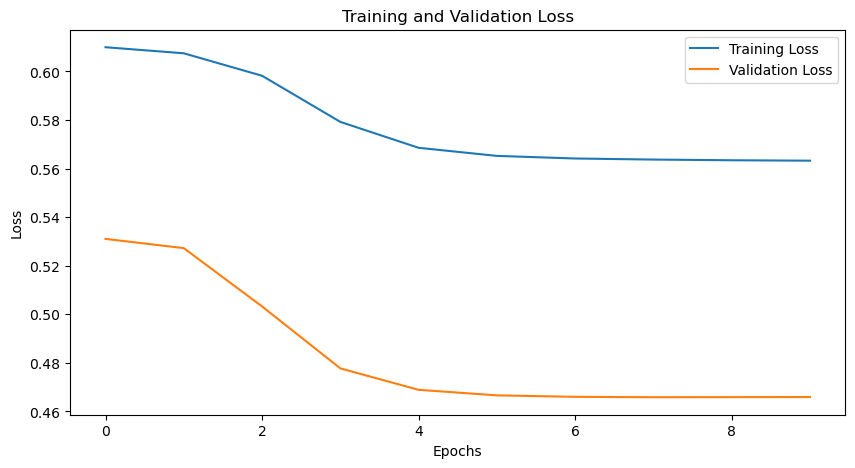

CPU times: user 11min 9s, sys: 1min 16s, total: 12min 25s
Wall time: 31.1 s


In [65]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
# input_dim = 128*5+1
input_dim = stock_number
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=1,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 10
patience = 3
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)

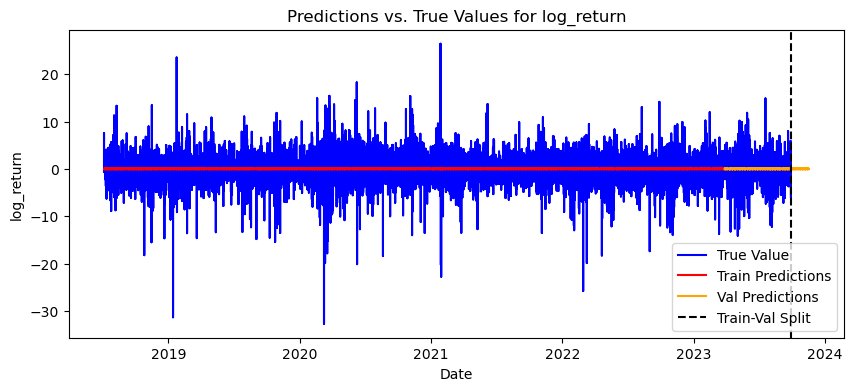

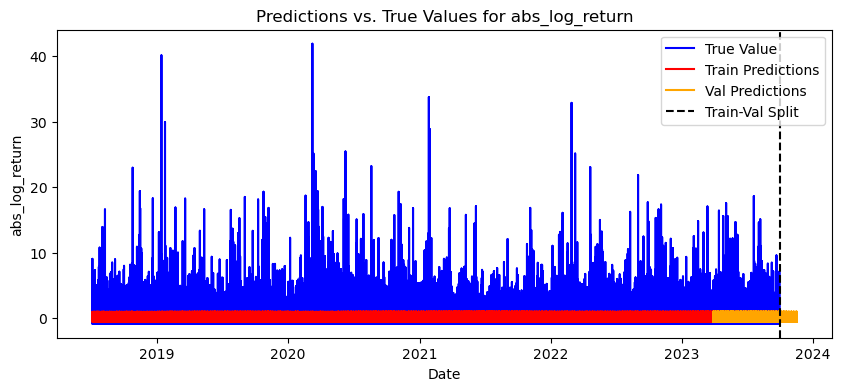

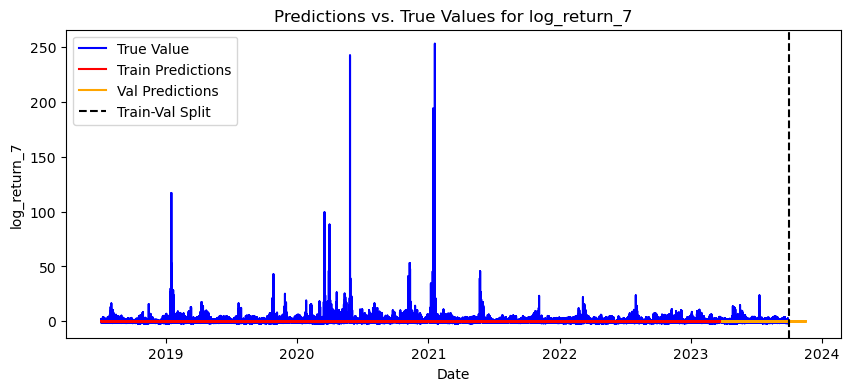

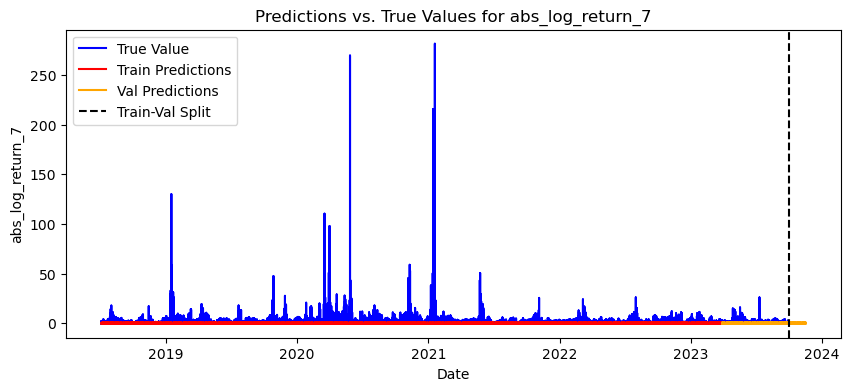

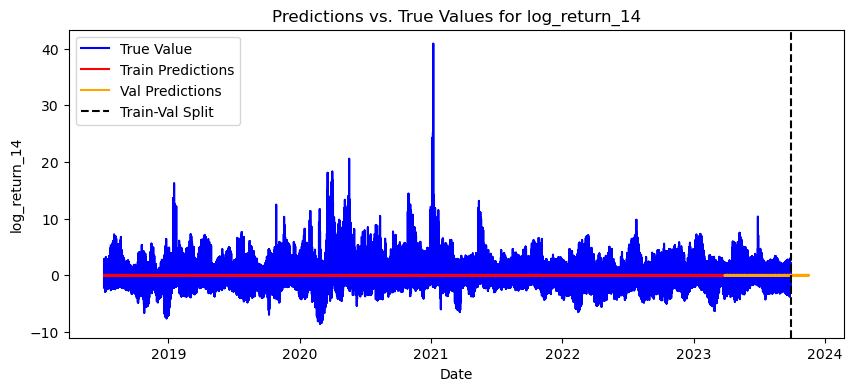

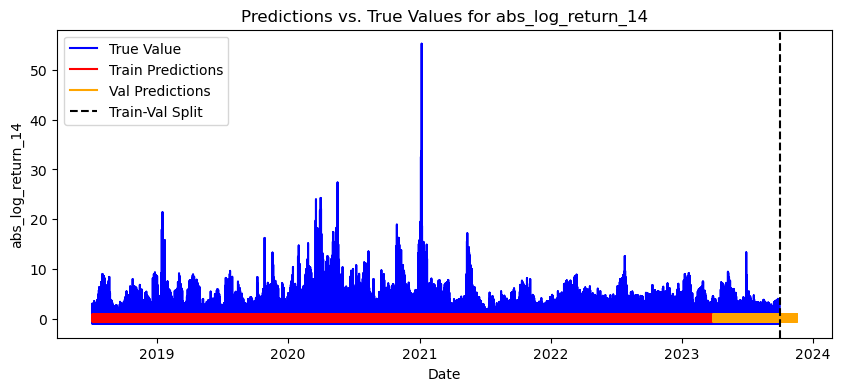

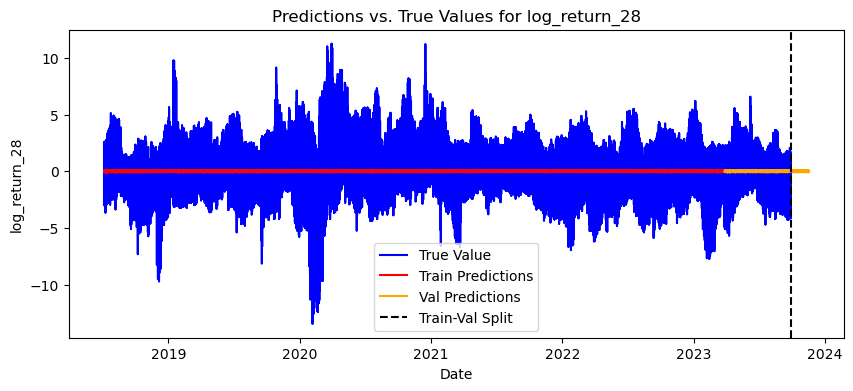

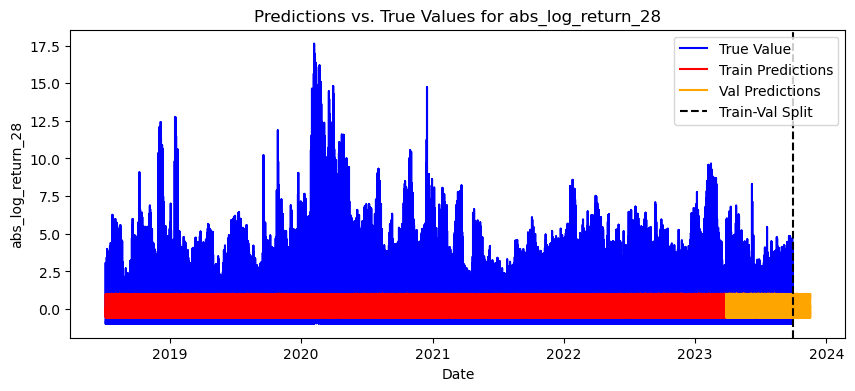

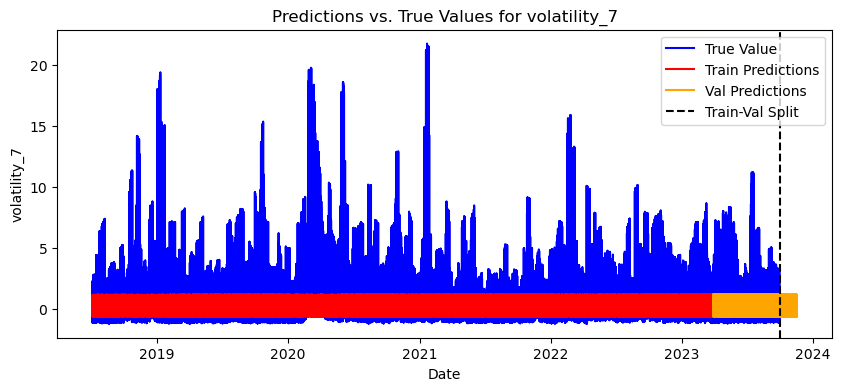

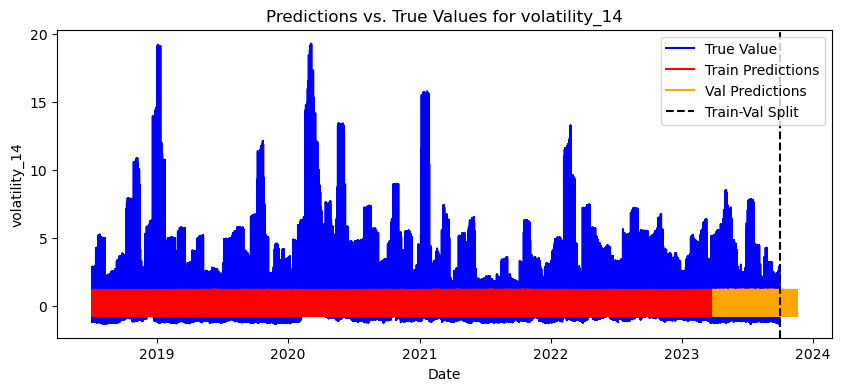

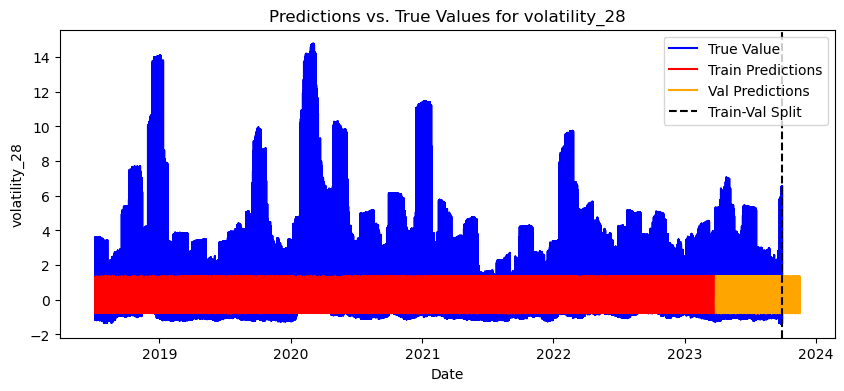

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Separate scaler for target columns
target_scaler = StandardScaler()
standardized_data[train_dataset.target_columns] = target_scaler.fit_transform(standardized_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            # print(output.shape)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-09-30'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


#### Input Embedding Weights

In [67]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy().T
print(input_embedding_weights)

[[-0.02142998  0.00465556 -0.03450064 ... -0.01520691  0.00056751
   0.04042878]
 [-0.00706649  0.00436713  0.02413492 ... -0.01713675 -0.04405581
   0.02308793]
 [-0.04031176 -0.02122733  0.04059267 ...  0.03466645  0.00115395
  -0.00894834]
 ...
 [-0.03878929  0.04397238 -0.00996786 ... -0.01090995 -0.01061951
  -0.00987472]
 [-0.02572725  0.01721251  0.0063031  ...  0.01537782  0.01686951
  -0.04038302]
 [-0.0146804   0.0023017   0.03784656 ... -0.04016291 -0.01083501
   0.00857184]]


In [68]:
input_embedding_weights.shape

(508, 256)

In [69]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

array([[ 0.9999994 , -0.07492055, -0.05603051, ...,  0.09710778,
        -0.04233129,  0.06280982],
       [-0.07492055,  0.99999934,  0.11093043, ..., -0.00996404,
         0.05635764,  0.08090699],
       [-0.05603051,  0.11093043,  1.0000002 , ..., -0.08250847,
         0.11404645,  0.03673276],
       ...,
       [ 0.09710778, -0.00996404, -0.08250847, ...,  0.9999999 ,
         0.03036796, -0.10163714],
       [-0.04233129,  0.05635764,  0.11404645, ...,  0.03036796,
         1.0000002 ,  0.08169111],
       [ 0.06280982,  0.08090699,  0.03673276, ..., -0.10163714,
         0.08169111,  1.0000001 ]], dtype=float32)

In [70]:
pd.DataFrame(cosine_sim_matrix_input_embedding_weights).to_csv("cosine_sim_matrix_input_embedding_weights554_3.csv")

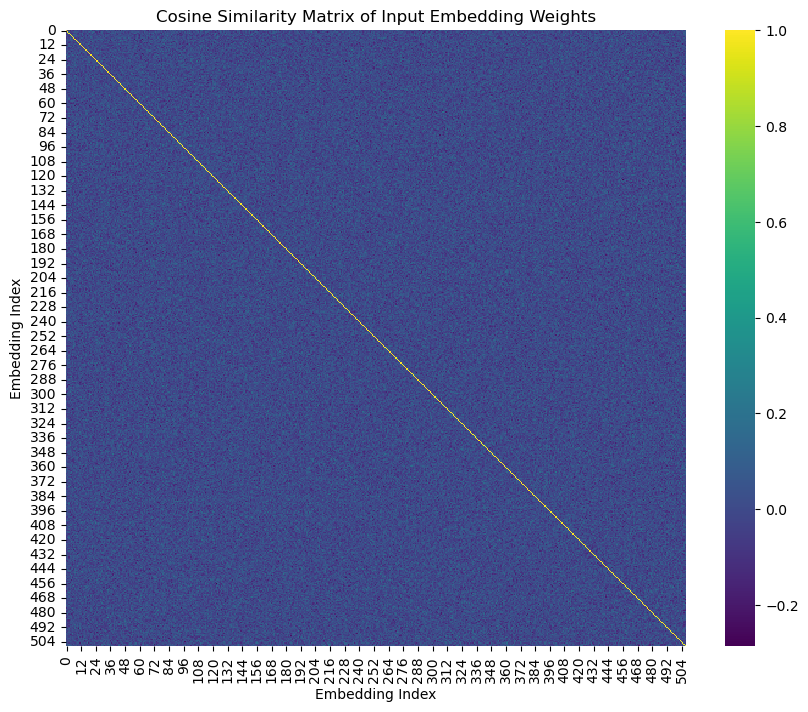

In [71]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Feed_Forward Weights

In [ ]:
# To get the weights of the first encoder layer
encoder_layer_weights = model.transformer.layers[0].state_dict()
encoder_layer_weights

In [ ]:
# If you want to get the weights of all encoder layers
all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
all_encoder_layers_weights

In [ ]:
# Attention weights
attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# Feedforward weights
feedforward_weights = encoder_layer_weights['linear1.weight']

print("Attention Weights:", attention_weights.shape)
print("Feedforward Weights:", feedforward_weights.shape)


In [ ]:
feedforward_weights_matrix = feedforward_weights.cpu().numpy()
feedforward_weights_matrix

In [ ]:
cosine_sim_matrix_feedforward_weights = cosine_similarity(feedforward_weights_matrix)
cosine_sim_matrix_feedforward_weights

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_feedforward_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Extract Last Output Embedding

In [ ]:

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))

In [ ]:
output_embedding_matrix = embeddings[:,-1,:].cpu().numpy()
output_embedding_matrix

In [ ]:
cosine_sim_matrix_out_embedding = cosine_similarity(output_embedding_matrix)
cosine_sim_matrix_out_embedding

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_out_embedding, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Output Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

#### Average Output Embedding

In [ ]:
# Initialize an empty tensor to accumulate the embeddings
accumulated_embeddings = torch.zeros(641, 256).to(device)
total_batches = 0

with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        #print(embeddings)
        accumulated_embeddings += embeddings.sum(dim=1)
        # total_batches += batch["features"].size(0)
        total_batches += embeddings.size(1)

# Divide the accumulated embeddings by the total number of batches to get the average
average_embeddings = accumulated_embeddings / total_batches
print(total_batches)
average_embeddings

In [ ]:
average_embeddings.shape

In [ ]:
batch["features"].shape

In [ ]:
batch["features"].size(0)

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity(average_embeddings.cpu().numpy()), annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()